# Home Assignment No. 2: Part 1 (Practice)
To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

To begin with, let's import the essential (for this assignment) libraries.

## Task 1.1. Boosting, part 1. (2 points)


> Boosting Machines (BM) are a family of widely popular and effective methods for classification and regression tasks. The main idea behind BMs is that **combining weak learners**, that perform slightly better than random, can result in **strong learning models**.

> AdaBoost utilizes the greedy training approach: firstly we train the weak learners (they are later called `base_classifiers`) on the whole dataset and in the next iterations we train the model on the samples, on the which the previous models have performed poorly. This behavior is acheived by reweighting the training samples during each algorithm's step. 

#### The task:

In this exercise you will be asked to implement one of the earlier variants of BMs - **AdaBoost** and compare it to the already existing `sklearn` implementation. The key steps are:

* Complete the `ada_boost_alpha` and `ada_boost_distribution` functions

* Complete the `.fit` method of `Boosting` class

* Complete the `.predict` method of `Boosting` class

The pseudocode for AdaBoost can be found in [Lecture 7](https://github.com/adasegroup/ML2020_lectures).

##### criteria

the decision boundary of the final implementation should look reasonably identical to the model from `sklearn`, and should achieve accuracy close to `scikit` :

$$
    |\text{your_accuracy} - \text{sklearn_accuracy}| \leq 0.005
\,. $$

#### Place for ypur solution

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss

In [0]:
### Plot the dataset

X, y = make_moons(n_samples=1000, noise=0.3, random_state=0)

# for convenience convert labels from {0, 1} to {-1, 1}
y[y == 0] = -1

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30),
                     np.linspace(y_min, y_max, 30))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

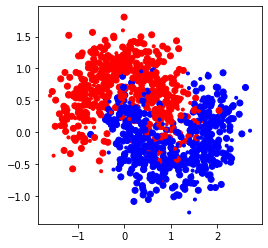

In [0]:
# Plot the training points
plt.figure(figsize=(4, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', c=y_test, cmap=cm_bright)

base classifier

In [0]:
from sklearn.tree import DecisionTreeClassifier

* `ada_boost_alpha` - function, which calculates the weights of the linear combination of the classifiers
* `ada_boost_distribution` - function, which calculates sample weights

Implement htese procedures

In [0]:
### Now let us define functions to calculate alphas and distributions for AdaBosot algorithm

def ada_boost_alpha(y, y_pred_t, distribution):
    """
    y_pred_t is a prediction of the t-th base classifier
    """
    # Weighted classification error
    N = zero_one_loss(y, y_pred_t, sample_weight= distribution)
    # Weight of a t-th tree
    alpha = 1/2*np.log((1-N)/N)
    return alpha

In [0]:
def ada_boost_distribution(y, y_pred_t, distribution, alpha_t):
    """
    y_pred_t is a prediction of the t-th base classifier
    """
    # Number of objects
    m = len(y)
    distribution_new = []
    distribution_normalized = []
    for k in range(0, m):
      # Updating a weight
      distribution_new += [distribution[k]*np.exp(-alpha_t*y[k]*y_pred_t[k])]
    norm = sum(distribution_new)
    for k in range(0, m):
      # Normalizing a weight
      distribution_normalized += [distribution_new[k]/norm]
    distribution = np.array(distribution_normalized)
    return distribution

Our custom boosting class

In [0]:
class Boosting():
    """
    Generic class for construction of boosting models
    
    :param n_estimators: int, number of estimators (number of boosting rounds)
    :param base_classifier: callable, a function that creates a weak estimator. Weak estimator should support sample_weight argument
    :param get_alpha: callable, a function, that calculates new alpha given current distribution, prediction of the t-th base estimator,
                      boosting prediction at step (t-1) and actual labels
    :param get_distribution: callable, a function, that calculates samples weights given current distribution, prediction, alphas and actual labels
    """
    def __init__(self, n_estimators=50, base_classifier=None,
                 get_alpha=ada_boost_alpha, update_distribution=ada_boost_distribution):
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution
        
    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples, dtype=float) / n_samples
        self.classifiers = []
        self.alphas = []
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())     
            self.classifiers[-1].fit(X, y, sample_weight=distribution)

            # ======= Your code here ======
            
            # make a prediction
            y_pred_t = self.classifiers[-1].predict(X)
            
            #update alphas, append new alpha to self.alphas
            alpha_t = ada_boost_alpha(y, y_pred_t, distribution)
            self.alphas += [alpha_t]
            
            # update distribution and normalize
            distribution = ada_boost_distribution(y, y_pred_t, distribution, alpha_t)

    
    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
    
        # ====== Your code here ======
        #get the weighted votes of the classifiers
        n_samples = len(X)
        y_pred = []
        for i in range(0, n_samples):
          y_pred_i = []
          for t in range(0, n_estimators):
            # Prediction for i-th object with help of t-th tree, multiplied by weight of t-th tree
              y_pred_i += [self.alphas[t]*self.classifiers[t].predict(X[i].reshape(1, -1))]
          y_pred_i = sum(y_pred_i)
          y_pred += [y_pred_i]
        out = np.array(np.sign(y_pred)).reshape(1, -1)



        return out

In [0]:
from sklearn.ensemble import AdaBoostClassifier

max_depth = 5
n_estimators = 100

get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)
ada_boost1 = Boosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf)
ada_boost1.fit(X_train, y_train)

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [0]:
classifiers = [ada_boost1, ada_boost_sklearn]
names = ['ada_boost', 'ada_boost_sklearn']

accuracy ada_boost: 0.875
accuracy ada_boost_sklearn: 0.875


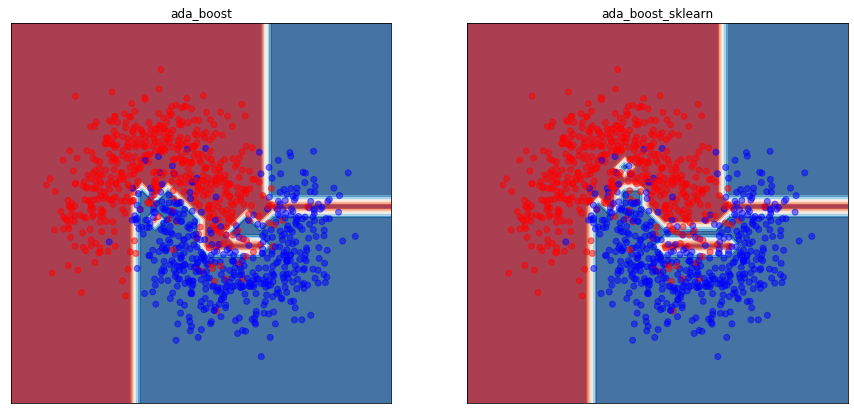

In [0]:
# # test ensemble classifier
plt.figure(figsize=(15, 7))
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))

## Task 1.2. Boosting, part 2. (2 points)

For adaboost we have computed each alpha according to the formula:

$$\alpha_t = \frac{1}{2}\log{\frac{1-N_T(h_T, w_T )}{N_T(h_T,w_t)}}$$

In the next task you will be asked to instead recompute all of the alphas after adding another estimator to the composition of models, i.e. when the new classifier is fitted to the weighted data samples, the new alphas should be recomputed by directly minimizing the exponential loss, for all the avaliable estimators. Take into account, that at each step of the boosting algorithm **all** alphas and, consequntly, **all** sample weights should be recomputed from scratch. 

**The task**:
* Complete the `recompute_alpha` and `recompute_distribution` functions
* Complete the `.fit` method of `RecomputeBoosting` class
* Complete the `.predict` method of `RecomputeBoosting` class
* Plot the final alphas (last calculated in case of recomputed alphas)
* plot the history scores of the resulting model at each iteration (use ```predict```, ```score``` and ```construct_alpha_history``` functions defined below) for both RecomputedBoosting and AdaBoost (it can be either your own implementation from Exercise 1.1 or the one from sklearn - in this case use ```.estimator_weights_```, ```.estimators_```)
* Make a conclusion about which method is better and in which case - in order to do that you can additionally vary the parameters of training: number and depth of the estimators, noise of the data (moons)

**HINTS:**

In order to minimize the exponential loss with respect to alpha, use the [```scipy.optimize.minimize```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function.

When defining the function to minimize (in case of AdaBoost it should be the exponential loss), have a look at the optimization problem formulation of Ridge Regression and at the reguralization parameter([Lecture 2, slide 14](https://github.com/adasegroup/ML2020_lectures/blob/master/lecture2/Lecture_2_Regression.pdf)). Add it in order to guarantee the existence of the solution.

In [0]:
from scipy.optimize import minimize

In [0]:
def recompute_alpha(y, y_pred, C):
    """
    y_pred - is a list of predictions of the existing estimators
    C - is a reguralization term
    """
    # ====== Your code here =====
    def fun(x):
      return np.sum( np.exp(-y*np.sum([x[i]*y_pred[i] for i in np.arange(len(y_pred))], axis=0))) + C
    alphas_initial = np.ones(len(y_pred)  ) 
    res = minimize(fun, x0 = alphas_initial, method = 'BFGS' )
    alphas = res.x   
    return alphas
    

def recompute_distribution(y, y_pred, alphas):
    """
    y_pred - is a list of predictions of the existing estimators
    alphas - are the last recomputed alphas
    """
    # ====== Your code here =====
    distribution = np.exp(-y*np.sum([alphas[i]*y_pred[i] for i in np.arange(len(y_pred))], axis=0))
    distribution = distribution / np.sum(distribution)
    return distribution

In [0]:
class RecomputedBoosting():
    """
    Generic class for construction of boosting models
    
    :param n_estimators: int, number of estimators (number of boosting rounds)
    :param base_classifier: callable, a function that creates a weak estimator. Weak estimator should support sample_weight argument
    :param get_alpha: callable, a function, that calculates new alpha given current distribution, prediction of the t-th base estimator,
                      boosting prediction at step (t-1) and actual labels
    :param get_distribution: callable, a function, that calculates samples weights given current distribution, prediction, alphas and actual labels
    """
    def __init__(self, n_estimators=50, base_classifier=None,
                 get_alpha=recompute_alpha, update_distribution=recompute_distribution, C=1.0):
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution
        self.C = C
        
    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples, dtype=float) / n_samples
        self.classifiers = []
        
        #notice how alpha is a matrix - we will store the history of the updates here
        self.alphas = np.zeros((n_estimators, n_estimators))
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())        
            self.classifiers[-1].fit(X, y, sample_weight=distribution)
            
            
            # ======= Your code here ======
            # create a list of predictions across all classifiers
            y_pred = np.array([self.classifiers[i].predict(X) for i in np.arange(len(self.classifiers))])


            # recalculate alphas, add them to the matrix of self.alphas 
            # NOTE: here, self.alphas is a history of computed alphas at each step i
            C = self.C*np.linalg.norm(distribution)**2
            new_alpha = self.get_alpha(y, y_pred, C)
            # when t < n_estimators, add zeros to the end
            for j in range(i):
               self.alphas[i][j] = new_alpha[j]
            
            # update distribution and normalize
            distribution = recompute_distribution(y, y_pred, new_alpha)
            
    
    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
    
        # ====== Your code here ======
        #get the weighted votes of the classifiers
        #do not forget that self.alphas is the whole history of recalculated alphas!
        n_samples = len(X)
        y_pred = []
        for i in range(0, n_samples):
          y_pred_i = []
          for t in range(0, n_estimators):
            # Prediction for i-th object with help of t-th tree, multiplied by weight of t-th tree
              y_pred_i += [self.alphas[-1][t]*self.classifiers[t].predict(X[i].reshape(1, -1))]
          y_pred_i = sum(y_pred_i)
          y_pred += [y_pred_i]
        out = np.array(np.sign(y_pred)).reshape(1, -1)

        
        return out

In [0]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost = RecomputedBoosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf, get_alpha=recompute_alpha, 
                     update_distribution=recompute_distribution, C=1.0)
ada_boost.fit(X_train, y_train)

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [0]:
classifiers = [ada_boost, ada_boost_sklearn]
names = ['ada_boost', 'ada_boost_sklearn']

accuracy ada_boost: 0.9
accuracy ada_boost_sklearn: 0.875


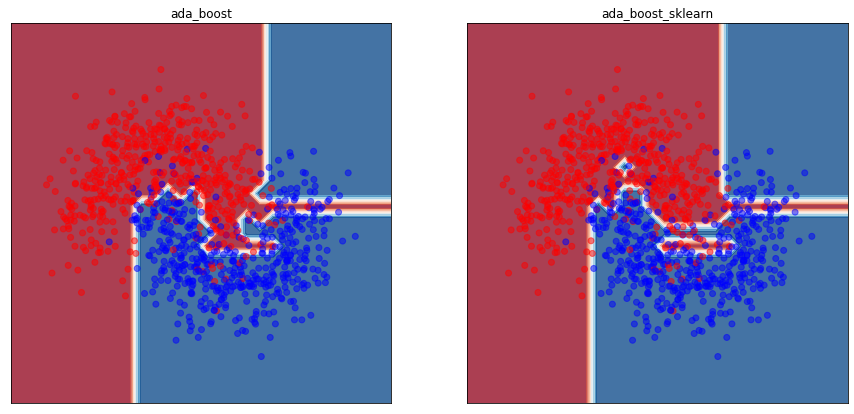

In [0]:
# # test ensemble classifier
plt.figure(figsize=(15, 7))
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))

In [0]:
from sklearn.metrics import accuracy_score

def score(alphas, estimators, X, y):
    return accuracy_score(y, predict(alphas, estimators, X))

def predict(alphas, estimators, X, y=None):
    return np.sign(sum(
        b * e.predict(X) for b, e in zip(alphas, estimators)
    ))

def construct_alpha_history(init_alphas):
    """
    construct alpha history, alike recomputed alpha history, for AdaBoost algorithm
    """
    alphas = np.zeros((len(init_alphas), len(init_alphas)))
    for t, alpha in enumerate(init_alphas):
        alphas[t:, t] = alpha
    return alphas

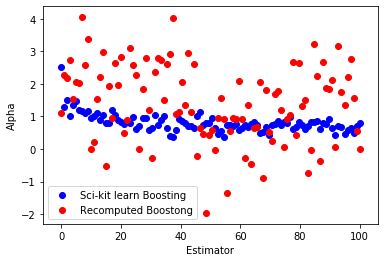

In [0]:
## Plot the resulting alphas (last calculated in case of recomputed alphas)
sklearn_alphas = construct_alpha_history(ada_boost_sklearn.estimator_weights_)
recomputed_alphas = ada_boost.alphas
i = np.linspace(0, n_estimators, num=n_estimators)
plt.scatter(i, sklearn_alphas[-1], c='b', label='Sci-kit learn Boosting')
plt.scatter(i, recomputed_alphas[-1], c='r', label='Recomputed Boostong')
plt.xlabel('Estimator')
plt.ylabel('Alpha')
plt.legend()
plt.show()

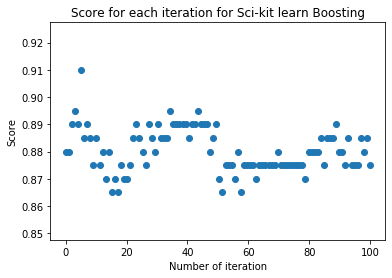

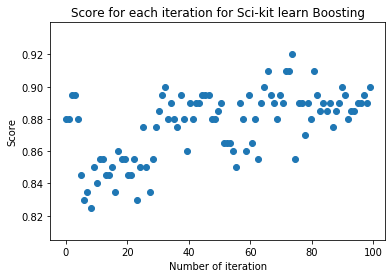

In [0]:
## Plot the scores of the models at each iteration (each iteration - each estimator added to the ensemble) 
## for AdaBoost and RecomputedAdaBoost
sklearn_score = []
iteration = np.linspace(0, n_estimators, num=n_estimators)
for i in np.arange(n_estimators):
    sklearn_score.append(score(sklearn_alphas[i], ada_boost_sklearn.estimators_, X_test, y_test))
plt.scatter(iteration, sklearn_score)
plt.xlabel('Number of iteration')
plt.ylabel('Score')
plt.title('Score for each iteration for Sci-kit learn Boosting')
plt.show()
iteration = np.linspace(0, n_estimators-1, num=n_estimators-1)
recomputed_score = []
for i in np.arange(1,n_estimators):
    recomputed_score.append(score(recomputed_alphas[i], ada_boost.classifiers, X_test, y_test))
plt.scatter(iteration, recomputed_score)
plt.xlabel('Number of iteration')
plt.ylabel('Score')
plt.title('Score for each iteration for Sci-kit learn Boosting')
plt.show()

Make a conclusion about which method is better and in which case. 

I think, that due to often recalculation of the set of alphas the Ada Boost  should have shown better results. It minimizes loss function each iteration for all the alphas, and thus, reevaluating the contribution of every stump into the model. In practice, as we can see, it may not increase score significantly, but certainly will increase time costs of calculation. From this, I can assume, that the use of recomputed alphas may be excused by necessity of accuracy increase

## Task 2. Gradient Boosting and Feature Selection (1 point)

Gradient Boosting Machines (GBM) are a historical and logical continuation of the first boosting algorithms. In a way, one can consider AdaBoost as another variant of GBMs. These methods are the extremely powerful tools, widely used in industry, research and various machine learning competitions. 

In this task we offer to focus on one varinat of GBM called [XGBoost](https://github.com/dmlc/xgboost/tree/master/python-package). The dataset that is going to be used is  [Telecom Churn Dataset] (https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). You will need to construct an XGBoost classification model, train it, plot the ROC curve, measure the training time and compare it to Random Forest. Afterwards, compare the models' feature importances. 

**The task**
* train the XGBoost classifier on the provided dataset
  * measure the training time
  * measure the precision/recall on the test set
  * plot ROC-curve

* train Random Forest classifier and compare it to XGBoost (plot ROC-curve)

* compare the feature importances of the trained XGBoost and Random Forest Classifiers. Why do you think they are different? Explain.

* for each model, sort the features by their importance, and plot the dependence of the test score on the number of features selected by best importance

*Fit the models to the iteratively reduced subset of features -in order to fo that, firstly, sort the feature importances in the decreasing order; then fit the models on the iteratively reduced feature subsets corresponding to the currently chosen threshold of the feature importance and plot the precision-recall.

**HINT**: you can use ```sklearn.feature_selection.SelectFromModel``` and  its ```.transform``` methods in order to get the new $X$,$y$ subsets (according to the current threshold of the feature importance).

Make sure that you have installed the XGBoost package before starting the task. 

**HINT**: in order to measure the training time you can use [**timeit** cell magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit). 

In [0]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_curve

data = pd.read_csv('data/telecom_churn.csv')
cols = ['account length','number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn']
data = data[cols]
data.iloc[:,-1] = pd.Categorical(data.iloc[:,-1])
data.iloc[:,-1] = data.iloc[:,-1].cat.codes
X, y = data.iloc[:,:-1], data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=0x0BADBEEF)

* train the XGBoost classifier on the provided dataset
* measure the training time
* measure the precision/recall on the test set
* plot ROC-curve
* train Random Forest classifier and compare it to XGBoost (plot ROC-curve)

Training time:
10 loops, best of 3: 176 ms per loop
Pricision score = 0.88 	 Recall score = 0.5472636815920398


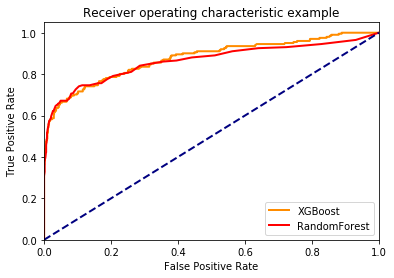

In [0]:
###YOUR CODE###
# XGBoost
xgbc = XGBClassifier()
print('Training time:')
%timeit(xgbc.fit(X_train, y_train))
y_pred = xgbc.predict(X_test)
# Scores
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Pricision score =', precision, '\t', 'Recall score =', recall)
# Probabilities for constructing ROC-curve
y_pred_prob_xgbc = xgbc.predict_proba(X_test)
# Random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
# Probabilities for constructing ROC-curve
y_pred_prob_rf = rf.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgbc[:, 1])
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_prob_rf[:, 1])

# Plotting Roc-curve
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='XGBoost')
plt.plot(fpr1, tpr1, color='red',
lw=lw, label='RandomForest')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

* extract and compare the feature importances calculated by the previously trained XGBoost and Random Forest Classifiers. Are they different or the same, why?

In [0]:
###YOUR CODE###
print('XGBoost importances:',*xgbc.feature_importances_, '\n', 'RandomForest importances:',*rf.feature_importances_)
print('Their difference', *(xgbc.feature_importances_-rf.feature_importances_))

XGBoost importances: 0.038534027 0.14306855 0.1907089 0.031754125 0.0 0.105586395 0.030265067 0.0 0.04275361 0.035613164 0.0 0.0649615 0.09308082 0.0 0.22367378 
 RandomForest importances: 0.050402536642085945 0.04215329968924047 0.1396243301749893 0.04715852185087697 0.15070070606272698 0.07517421679224126 0.04044245516845577 0.07749829606392326 0.0457881584554181 0.0425410440986831 0.04698502372380305 0.046947450807021666 0.031075435977809852 0.0518416711905639 0.11166685330216046
Their difference -0.01186851004911605 0.10091525232797144 0.051084575283461026 -0.01540439694123761 -0.15070070606272698 0.030412177875384167 -0.010177388395756416 -0.07749829606392326 -0.0030345476954445755 -0.006927879792996153 -0.04698502372380305 0.018014049658848237 0.06200538267529684 -0.0518416711905639 0.11200692248996143


* Fit the models to the iteratively reduced subset of features -in order to fo that, firstly, sort the feature importances in the decreasing order; then fit the models on the iteratively reduced feature subsets corresponding to the currently chosen threshold of the feature importance and plot the precision-recall. **HINT**: you can use ```sklearn.feature_selection.SelectFromModel``` and  its ```.transform``` methods in order to get the new $X$,$y$ subsets (according to the current threshold of the feature importance).

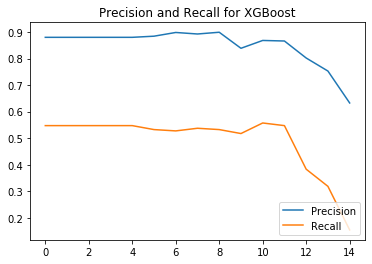

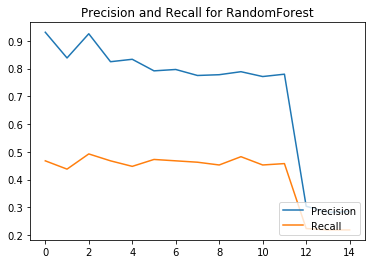

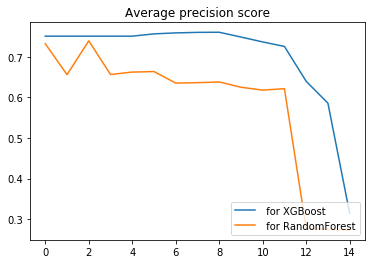

In [0]:
###YOUR CODE###
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import average_precision_score
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
feat_import = np.sort(xgbc.feature_importances_)
# Calculation values for constructing curves of precision, recall
# and average_precision-threshold dependance
precision = []
recall = []
aps_xgbc = []
for i in feat_import:
  # Selection of features, that satisfy the threshold
  selector = SelectFromModel(estimator=xgbc, threshold = i).fit(X_train, y_train)
  X_train_new = selector.transform(X_train)
  X_test_new = selector.transform(X_test)
  selector.estimator.fit(X_train_new, y_train)
  y_pred_new = selector.estimator.predict(X_test_new)
  precision += [precision_score(y_test, y_pred_new)] 
  recall += [recall_score(y_test, y_pred_new)] 
  y_pred_new_prob = selector.estimator.predict_proba(X_test_new )
  aps_xgbc += [average_precision_score(y_test, y_pred_new_prob[:, 1])]
plt.plot(range(feat_import.shape[0]), precision, label='Precision')
plt.plot(range(feat_import.shape[0]), recall, label='Recall')
plt.title('Precision and Recall for XGBoost')
plt.legend(loc="lower right")
plt.show()
# The same for Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
feat_import = np.sort(rf.feature_importances_)
precision_rf = []
recall_rf = []
aps_rf = []
for i in feat_import:
  selector_rf = SelectFromModel(estimator=rf, threshold = i).fit(X_train, y_train)
  X_train_new = selector_rf.transform(X_train)
  X_test_new = selector_rf.transform(X_test)
  selector_rf.estimator.fit(X_train_new, y_train)
  y_pred_new = selector_rf.estimator.predict(X_test_new)
  precision_rf += [precision_score(y_test, y_pred_new)] 
  recall_rf += [recall_score(y_test, y_pred_new)] 
  y_pred_new_rf_prob = selector_rf.estimator.predict_proba(X_test_new)
  aps_rf += [average_precision_score(y_test, y_pred_new_rf_prob[:, 1])]
# Precision and Recall
plt.plot(range(feat_import.shape[0]), precision_rf, label='Precision')
plt.plot(range(feat_import.shape[0]), recall_rf, label='Recall')
plt.title('Precision and Recall for RandomForest')
plt.legend(loc="lower right")
plt.show()
# Average_precision_score-threshold
plt.plot(range(feat_import.shape[0]), aps_xgbc, label=' for XGBoost')
plt.plot(range(feat_import.shape[0]), aps_rf, label=' for RandomForest')
plt.title('Average precision score')
plt.legend(loc="lower right")
plt.show()

# Task 3. Bayesian methods (1 point)

In this task you are asked to compare the performance of the common Ridge Regression with its the parameters chosen using cross-validation technique and Bayesian Ridge Regression. 

In particular, using [Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html), find the optimal value for the reguralization coefficient in the ridge regression optimization problem formulation. Then train [Bayesian Regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression) and compare the absolute error and learnt coefficients distribution for both variants and make some conclusions on both methods.

**The task:** 
* Use crossvalidation technique to choose the optimal value of reguralization coefficent for Ridge Regression model. (**Note:** "optimal" value here, means the one that lets the model with this particular parameter value achieve better performance compared to the other variants). 
* Fit Bayesian Ridge Regression model 
* Plot the absolute error historgramms for both models using [seaborn.distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html).
* Plot historgrams of coefficients of regression derived from both models (in cross-validation case the coefficients of the best model)
* Compare the two pairs of histrograms. Are they the same or different? Why? What are the prons and cons of both methods?

In [0]:
import sklearn.datasets as dt
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, BayesianRidge
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [0]:
X,y = dt.load_boston(return_X_y=True)
X_train = X[:400]
y_train = y[:400]
X_test = X[400:]
y_test = y[400:]

Optimal value of regularization coefficient is  {'alpha': 100}
Mean absolute error for Ridge Regressian is 4.063838707876296
Mean absolute error for Bayesian Regressian is 4.755341579202944


Text(0.5, 0, 'Coefficient')

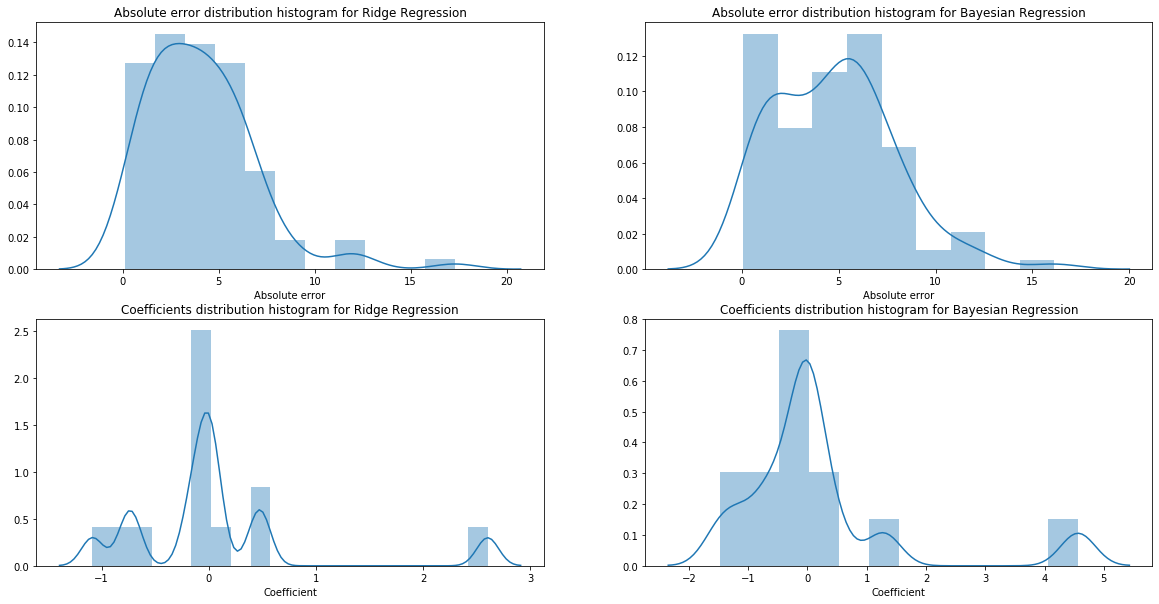

In [0]:
###YOUR CODE###
# Looking for the best parameters for ridge with help of gridsearch
lr = Ridge( )
params = {'alpha':[0.1, 1, 10, 100, 1000]}
gs_lr = GridSearchCV(estimator = lr, param_grid=params, scoring = 'neg_mean_absolute_error', cv =5, n_jobs = -1)
gs_lr.fit(X_train, y_train)
# Coefficients for Ridge
coef_lr = gs_lr.best_estimator_.coef_
# Prediction and error
y_pred_lr = gs_lr.predict(X_test)
print('Optimal value of regularization coefficient is ', gs_lr.best_params_)
err_lr = mean_absolute_error(y_test, y_pred_lr)
dist_lr = abs(y_test-y_pred_lr)
print('Mean absolute error for Ridge Regressian is', err_lr)
#Bayesian ridge regression
br =  BayesianRidge()
br.fit(X_train, y_train)
# Coefficients for Bayes Ridge
coef_br = br.coef_
# Prediction and error
y_pred_br = br.predict(X_test)
err_br = mean_absolute_error(y_test, y_pred_br)
dist_br = abs(y_test-y_pred_br)
print('Mean absolute error for Bayesian Regressian is', err_br)

#Plotting figures
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.distplot(a = dist_lr)
plt.title('Absolute error distribution histogram for Ridge Regression')
plt.xlabel('Absolute error')

plt.subplot(2,2,2)
sns.distplot(a = dist_br)
plt.title('Absolute error distribution histogram for Bayesian Regression')
plt.xlabel('Absolute error')

plt.subplot(2,2,3)
sns.distplot(a = coef_lr)
plt.title('Coefficients distribution histogram for Ridge Regression')
plt.xlabel('Coefficient')

plt.subplot(2,2,4)
sns.distplot(a = coef_br)
plt.title('Coefficients distribution histogram for Bayesian Regression')
plt.xlabel('Coefficient')

Diagramms for both methods look pretty similar, but absolute error for bayesian regressian seems to have two mods, but for ridge regression only one. Coefficient distribution for ridge regression has large peaks near zero and some convex parts, which means, that ridge regression tries to lower weights for not correlating features and assign higher weights with higher correlation. For Bayesian regression coefficient distribution is more uniform which reflects its probabilistic nature. Ridge regression is more suitable whenthere is a strong corellation between features and labels and Bayesian when you want to create a probabilistic model to take into account errors due to randomness of variables.

# Task 4. Stacking (2 point)

Stacking is another approach to combine several algorithms to get better results.Basically stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The main concept is to learn base models on some set of features then train meta model, which uses the predictions of base models as features. This technique is wiledly used in multiple real case scenarios to get better results. One of the main problem of stacking is, of course, overfitting. To avoid it, the training set is divided into $ n $ folds, $ (n-1) $ of which are used for training the base models, and $ n $ -th for the overall prediction (calculating the meta-factor). In order to train the meta-model, it should receive predictions from the base models for those objects of the training sample on which the meta-model will be trained. 

There are various of stacking approaches$.^{[1]}$ For example, in order, to obtain meta-factors for test data, the base classifiers can be trained on the entire training set, since the problem of overfitting does not arise here. In other words, if we want to calculate the factors for the test set, we can safely use the training set to train the base classifiers. If we want to calculate factors for the training set, then it is necessary to ensure that the classifier does not predict for those objects on which it has been trained$.^{[2]}$ You can read more details about stacking [blockpost](https://blog.statsbot.co/ensemble-learning-d1dcd548e936), [kaggle ensemble guide](https://mlwave.com/kaggle-ensembling-guide/).

P.s. Stacking and Blending are two similar approaches to combining classifiers (ensembling). The difference is that Stacking uses out-of-fold predictions for the train set, and Blending uses a validation set to train the next layer [source](quora.com/What-are-examples-of-blending-and-stacking-in-Machine-Learning). Because they are so similar you can use any of them. 

[1] http://www.machinelearning.ru/wiki/images/5/56/Guschin2015Stacking.pdf  
[2] MLgroup SHAD

**The task:**

* Complete the ```meta_classfier``` function
* Choose 6 different base models(base models can be any models that you know, and can differ between each other by different hyperparameters, models of ml,features e.t.c) and train them.
* Report individual scores on test set for each of the models. As a score use accuracy.
* Train metaclassifier on original datasets features, report score on test.
* Train meta_classifier on those base models. Report the test score (accuracy) in this case.
* Does stacking helped to gain better score?

Enough of theory, let's get back to Practice. Download dataset fetch_covertype from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html#sklearn.datasets.fetch_covtype) and  split it train-test - 60/40.
More detail about this dataset you can find [here](https://archive.ics.uci.edu/ml/datasets/Covertype)

In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
fc = datasets.fetch_covtype()
X_train, X_test, y_train, y_test = train_test_split(fc.data, fc.target, test_size=0.4, random_state = 0)

Write meta classifier function.

In [0]:
def meta_classifier(base_clfs, final_classifier, X_train, X_test, y_train, cv):
    """
    Meta classifier prediction using stacking. 
    Input:
    :param base_clfs: list,  base classifiers which will be stacked together.
    :param final_classifier: estimator, a classifier which will be used to combine the base estimators. 
    :param X_train: numpy array or pandas table, train set.
    :param X_test: numpy array or pandas table, target for train set.
    :param X_train: numpy array or pandas table, test set.
    
    Output:
    :param y_pred: numpy array or pandas table, prediction of meta classifier using stacking on test set.
    :param final_classifier(optional): estimator, trained final_calssifier.
    
    
    More details https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
    
    """
    ###YOUR CODE###
    meta_class = final_classifier
    y_pred_bc = []
    for i in range(len(base_clfs)):
      # Using the cross validation procedure to predict estimations, that meta-classifiers will use
      y_pred_bc += [cross_val_predict(estimator=base_clfs[i], X = X_train, y=y_train,  cv=cv)]
    y_pred_bc = np.array(y_pred_bc).T

    meta_class.fit(y_pred_bc,y_train)

    y_pred_test_bc = []
    for i in range(len(base_clfs)):
      base_clfs[i].fit(X_train, y_train)
      y_pred_test_bc += [base_clfs[i].predict(X_test)]
    y_pred_test_bc = np.array(y_pred_test_bc).T

    y_pred = meta_class.predict(y_pred_test_bc)
    
    return y_pred, meta_class


Chose 6 different base models(base models can be any models that you know,and can differ with each other by different hyperparameters,  models of ml,features e.t.c) and train them. 

In [0]:
###YOUR CODE###
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Set of estimators
dtc = DecisionTreeClassifier(random_state=0, max_depth = 4)
dtc1 = DecisionTreeClassifier(random_state=0, max_depth = 10)
rfc = RandomForestClassifier(random_state=0, max_depth = 4, n_estimators = 25)
etc = ExtraTreeClassifier(random_state=0)
gnb = GaussianNB()
knc = KNeighborsClassifier(n_neighbors=3)
base_clfs = [dtc, dtc1, rfc, etc, gnb, knc]
for i in range(len(base_clfs)):
  base_clfs[i].fit(X_train, y_train)

Report individual scores on test set. As a score use accuracy.

In [0]:
###YOUR CODE###
from sklearn.metrics import accuracy_score
names = ['DecisionTree with a depth 4', 'DecisionTree with a depth 10', 'RandomForest', 'ExtraTree', 'GaussianNB', 'KNN']
for i in range(len(base_clfs)):
  y_pred = base_clfs[i].predict(X_test)
  print('Accuracy score for', names[i], '=', accuracy_score(y_test, y_pred))
  

Accuracy score for DecisionTree with a depth 4 = 0.6990426195649836
Accuracy score for DecisionTree with a depth 10 = 0.7773627933994536
Accuracy score for RandomForest = 0.6772100428131925
Accuracy score for ExtraTree = 0.8507390116391644
Accuracy score for GaussianNB = 0.45897893763042963
Accuracy score for KNN = 0.9636883888040274


Train metaclassifier on original datasets features. And report score on test.

In [0]:
###YOUR CODE###
final_classifier = DecisionTreeClassifier(random_state=0, max_depth=10)
final_classifier.fit(X_train, y_train)
y_pred = final_classifier.predict(X_test)
print('Accuracy score for meta-classifier =', accuracy_score(y_test, y_pred))

Accuracy score for meta-classifier = 0.7773627933994536


Train meta_classifier on those base models .

In [0]:
###YOUR CODE###
import numpy as np
final_classifier = DecisionTreeClassifier(random_state=0, max_depth=10).fit(X_train, y_train)
result = meta_classifier(base_clfs, final_classifier,X_train, X_test, y_train, cv=5)

Report score(accuracy) on test. 

In [0]:
###YOUR CODE###
print('Accuracy =', accuracy_score(y_test, result[0]))

Accuracy = 0.9639465588089757


Does stacking helped to gain better score?

Your answer

Yes, stacking helped (accuracy 0.96 vs 0.77) because it uses predictions of many other models. Basically, base models have their pros and cons, but if we look at the test score of a meta classifier without staking and with stacking, we can see, that, obviously, stacking tries to get the best out of base classifiers.

# Task 5. Gaussian Processes (1 point)

In the following exercise you will need to fit the gaussian process with different kernels on the ```elecricity_conpumption_FR.csv``` time series data. We have already loaded and prepared the train/test datasets for you below.

Use [**GPy**](https://pypi.python.org/pypi/GPy) library for training and prediction. Fit a GP and run the predict on the test. Useful kernels to combine: `GPy.kern.RBF, GPy.kern.Poly, GPy.kern.StdPeriodic, GPy.kern.White, GPy.kern.Linear`. 

**The task**:
* Normalize the target value by fitting a transformation on the train (use ```sklearn.preprocessing.StandardScaler```)
* Plot the resulting target against the time index.
* Plot mean and confidence interval of the prediction. 
* Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
* Estimate the prediction error with `r2_score`. R2-score accepted > 0.7 on test sample.

In [0]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [0]:
data = pd.read_csv('data/elecricity_conpumption_FR.csv')


In [0]:
data.dropna(inplace=True)

In [0]:
y = np.array(data.values)
X = np.array(data.index)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

* Normalize the target value by fitting a transformation on the train (use ```sklearn.preprocessing.StandardScaler```)
* Plot the resulting target against the time index.

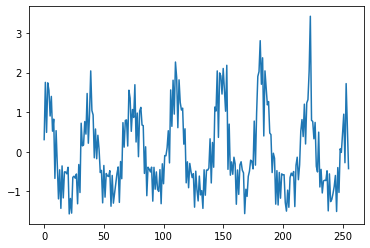

In [0]:
###YOUR CODE###
scaler = StandardScaler()
scaler.fit(y_train)
y_train_scaled = scaler.transform(y_train)
plt.plot(X_train , y_train_scaled)

In [0]:
!pip install -q GPy
from GPy.models import GPRegression
from GPy.kern import RBF, Poly, StdPeriodic, White, Linear,PeriodicExponential
from sklearn.metrics import r2_score
import GPy.kern as kern

     |████████████████████████████████| 1.0MB 4.8MB/s 
     |████████████████████████████████| 71kB 7.6MB/s 


* Plot mean and confidence interval of the prediction. 
* Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
* Estimate the prediction error with `r2_score`. R2-score accepted > 0.7 on test sample.

R2 score is 0.75


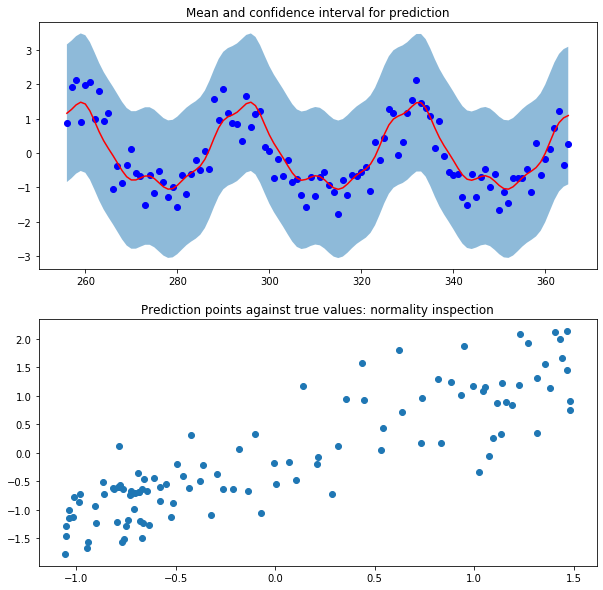

In [0]:
###YOUR CODE###
# Kernel, that corresponds to data
ker = StdPeriodic(1, period= 36.68, variance=10**6 )
# GP model
gpr = GPRegression(X_train,y_train_scaled,ker)
y_pred = gpr.predict(X_test)
# Scaling the test labels to evaluate R2
y_test_scaled = scaler.transform(y_test)
print('R2 score is', round(r2_score(y_test_scaled, y_pred[0]), ndigits =3))
# Confidence intervals
confidence = gpr.predict_quantiles(X_test )
# Plotting
plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
plt.title('Mean and confidence interval for prediction')
plt.fill_between(X_test.T[0], confidence[0].T[0], confidence[1].T[0], alpha=.5 )
plt.plot(list(X_test.T[0]), y_pred[0], c  = 'red')
plt.scatter(X_test, y_test_scaled, c ='blue')
plt.subplot(2,1,2)
plt.scatter(y_pred[0], y_test_scaled)
plt.title('Prediction points against true values: normality inspection')
plt.show()
